In [1]:
!pip install deepctr_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 835.3 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 37.2 MB/s eta 0:00:0000:0100:01
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77040 sha256=bc726efc23c2357f5dff4d8978119bb697a7607f0e4ee589e8e78dc9458bdf86
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.1
    Uninstalling wrapt-1.14.1:
      Successfully uninstalled wrapt-1.14.1
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
  Attempting uninstall: six
    Found existing in

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import gc

import torch
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import *

plt.style.use('ggplot')

import warnings as w
w.filterwarnings(action='ignore')
pd.set_option('display.max_columns',None)

### Paper link: https://arxiv.org/pdf/1703.04247.pdf

In [3]:
!wget -c https://labs.criteo.com/wp-content/uploads/2015/04/dac_sample.tar.gz -O - | tar -xz

--2022-05-31 15:09:50--  https://labs.criteo.com/wp-content/uploads/2015/04/dac_sample.tar.gz
Resolving labs.criteo.com (labs.criteo.com)... 87.98.154.146
Connecting to labs.criteo.com (labs.criteo.com)|87.98.154.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8787154 (8.4M) [application/x-gzip]
Saving to: ‘STDOUT’

-                     2%[                    ] 179.39K   304KB/s               tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
-                   100%[===================>]   8.38M  5.51MB/s    in 1.5s    

2022-05-31 15:09:52 (5.51 MB/s) - written to stdout [8787154/8787154]

tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHIL

### Feature Explain
   1. sparse_feature : I1 ~ I27
   2. dense_feature : C1 ~ C14

In [4]:
columns = ['label', *(f'I{i}' for i in range(1, 14)), *(f'C{i}' for i in range(1, 27))]
data = pd.read_csv('dac_sample.txt', sep='\t', names=columns).fillna(0)
data

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,1.0,2.0,0.0,2.0,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,1.0,1.0,0.0,4.0,68fd1e64,f0cf0024,6f67f7e5,41274cd7,25c83c98,fe6b92e5,922afcc0,0b153874,a73ee510,2b53e5fb,4f1b46f3,623049e6,d7020589,b28479f6,e6c5b5cd,c92f3b61,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,0,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,1.0,3.0,3.0,45.0,287e684f,0a519c5c,02cf9876,c18be181,25c83c98,7e0ccccf,c78204a1,0b153874,a73ee510,3b08e48b,5f5e6091,8fe001f4,aa655a2f,07d13a8f,6dc710ed,36103458,8efede7f,3412118d,0,0,e587c466,ad3062eb,3a171ecb,3b183c5c,0,0
3,0,0.0,893,0.0,0.0,4392.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68fd1e64,2c16a946,a9a87e68,2e17d6f6,25c83c98,fe6b92e5,2e8a689b,0b153874,a73ee510,efea433b,e51ddf94,a30567ca,3516f6e6,07d13a8f,18231224,52b8680f,1e88c74f,74ef3502,0,0,6b3a5ca6,0,3a171ecb,9117a34a,0,0
4,0,3.0,-1,0.0,0.0,2.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,8cf07265,ae46a29d,c81688bb,f922efad,25c83c98,13718bbd,ad9fa255,0b153874,a73ee510,5282c137,e5d8af57,66a76a26,f06c53ac,1adce6ef,8ff4b403,01adbab4,1e88c74f,26b3c7a7,0,0,21c9516a,0,32c7478e,b34f3128,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,1.0,60,37.0,0.0,1.0,0.0,4.0,0.0,23.0,1.0,3.0,0.0,0.0,68fd1e64,91381efc,eacb18f6,f00be896,25c83c98,fe6b92e5,2489e185,985e3fcb,a73ee510,3b08e48b,4d1f7d97,d6b4fe71,954029f8,1adce6ef,a0602981,2a08cb76,e5ba7672,38b82d9f,21ddcdc9,b1252a9d,24e5131b,0,32c7478e,4fa16304,47907db5,72966777
99996,1,0.0,0,12.0,0.0,173121.0,0.0,0.0,3.0,10.0,0.0,0.0,0.0,0.0,68fd1e64,f0cf0024,6f67f7e5,41274cd7,4cf72387,fbad5c96,9e5d3694,0b153874,7cc72ec2,be289b53,699034a0,623049e6,a0edec24,1adce6ef,55dc357b,c92f3b61,e5ba7672,b04e4670,21ddcdc9,b1252a9d,60f6221e,0,32c7478e,43f13e8b,ea9a246c,731c3655
99997,0,10.0,2,1.0,26.0,482.0,60.0,10.0,11.0,60.0,1.0,1.0,0.0,59.0,8cf07265,c8687797,b063fe4e,4b972461,25c83c98,7e0ccccf,176dc88e,d7c4a8f5,a73ee510,3b08e48b,d2b7c44b,8cdc4941,68637c0d,b28479f6,dc96c4b0,3084c78b,07c540c4,a7e06874,21ddcdc9,a458ea53,514b7308,0,32c7478e,2fd70e1c,010f6491,ec26ad35
99998,0,0.0,390,43.0,4.0,345365.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,0e78bd46,a796837e,dffca8ba,0fa0d423,25c83c98,fe6b92e5,bc324536,51d76abe,7cc72ec2,5cad6330,2bcfb78f,93bab460,e6fc496d,cfef1c29,f0bf9094,6bb29970,e5ba7672,1cdbd1c5,0,0,d9d9202f,0,32c7478e,8fc66e78,0,0


In [5]:
data.isna().sum().sum()

0

0    77337
1    22663
Name: label, dtype: int64


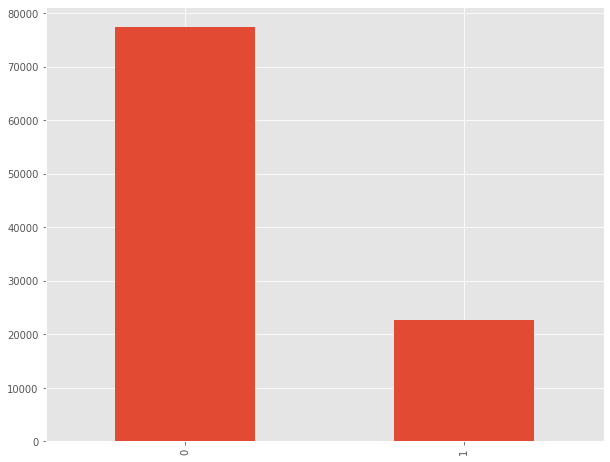

In [6]:
data.label.value_counts().plot(kind='bar',figsize=(10,8))
print(data.label.value_counts())

### Numerical data apply Robust Scaler

In [7]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
labeling = LabelEncoder()
data.iloc[::,1:14] = scaler.fit_transform(data.iloc[::,1:14])
dense_feature = data.iloc[::,14:40] 
for feature in dense_feature:
    fix_data = []
    for variable in dense_feature[feature]:
        if variable == 0:
            variable = 'a'
            fix_data.append(variable)
        else:
            fix_data.append(variable)
    dense_feature[feature] = fix_data
    dense_feature[feature] = labeling.fit_transform(dense_feature[feature])
    data.iloc[::,1:14] = scaler.fit_transform(data.iloc[::,1:14])
data.iloc[::,14:40] = dense_feature


In [8]:
if __name__ == "__main__":
    sparse_features = ['C' + str(i) for i in range(1, 27)]
    dense_features = ['I' + str(i) for i in range(1, 14)]
    
    target = ['label']

    
    fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique())
                              for feat in sparse_features] + [DenseFeat(feat, 1, )
                                                              for feat in dense_features]

    dnn_feature_columns = fixlen_feature_columns
    linear_feature_columns = fixlen_feature_columns

    feature_names = get_feature_names(
        linear_feature_columns + dnn_feature_columns)

    # 3.generate input data for model

    train, test = train_test_split(data, test_size=0.2, random_state=2020)
    train_model_input = {name: train[name] for name in feature_names}
    test_model_input = {name: test[name] for name in feature_names}

    # 4.Define Model,train,predict and evaluate

    device = 'cpu'
    use_cuda = True
    if use_cuda and torch.cuda.is_available():
        print('cuda ready...')
        device = 'cuda:0'

    model = DeepFM(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns,
                   task='binary',
                   l2_reg_embedding=1e-5, device=device)

    model.compile("adagrad", "binary_crossentropy",
                  metrics=["binary_crossentropy", "auc"], )

    history = model.fit(train_model_input, train[target].values, batch_size=512, epochs=50, verbose=1,
                        validation_split=0.2)
    pred_ans = model.predict(test_model_input, 256)
    print("")
    print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
    print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

cuda ready...
cuda:0
Train on 64000 samples, validate on 16000 samples, 125 steps per epoch


125it [00:03, 34.21it/s]


Epoch 1/50
3s - loss:  0.4763 - binary_crossentropy:  0.4763 - auc:  0.7276 - val_binary_crossentropy:  0.4572 - val_auc:  0.7563


125it [00:02, 46.30it/s]


Epoch 2/50
3s - loss:  0.3575 - binary_crossentropy:  0.3575 - auc:  0.8712 - val_binary_crossentropy:  0.4952 - val_auc:  0.7330


125it [00:02, 48.50it/s]


Epoch 3/50
2s - loss:  0.2435 - binary_crossentropy:  0.2435 - auc:  0.9429 - val_binary_crossentropy:  0.5618 - val_auc:  0.7153


125it [00:02, 48.38it/s]


Epoch 4/50
2s - loss:  0.1952 - binary_crossentropy:  0.1952 - auc:  0.9640 - val_binary_crossentropy:  0.6083 - val_auc:  0.7048


125it [00:02, 43.51it/s]


Epoch 5/50
3s - loss:  0.1712 - binary_crossentropy:  0.1712 - auc:  0.9726 - val_binary_crossentropy:  0.6521 - val_auc:  0.6995


125it [00:02, 47.36it/s]


Epoch 6/50
2s - loss:  0.1566 - binary_crossentropy:  0.1566 - auc:  0.9772 - val_binary_crossentropy:  0.6884 - val_auc:  0.6957


125it [00:02, 47.21it/s]


Epoch 7/50
2s - loss:  0.1458 - binary_crossentropy:  0.1458 - auc:  0.9802 - val_binary_crossentropy:  0.7247 - val_auc:  0.6931


125it [00:02, 45.38it/s]


Epoch 8/50
2s - loss:  0.1387 - binary_crossentropy:  0.1387 - auc:  0.9822 - val_binary_crossentropy:  0.7569 - val_auc:  0.6897


125it [00:02, 42.69it/s]


Epoch 9/50
3s - loss:  0.1324 - binary_crossentropy:  0.1324 - auc:  0.9839 - val_binary_crossentropy:  0.7838 - val_auc:  0.6880


125it [00:02, 41.71it/s]


Epoch 10/50
3s - loss:  0.1276 - binary_crossentropy:  0.1275 - auc:  0.9849 - val_binary_crossentropy:  0.8034 - val_auc:  0.6856


125it [00:02, 43.23it/s]


Epoch 11/50
3s - loss:  0.1240 - binary_crossentropy:  0.1240 - auc:  0.9860 - val_binary_crossentropy:  0.8298 - val_auc:  0.6851


125it [00:02, 45.50it/s]


Epoch 12/50
2s - loss:  0.1205 - binary_crossentropy:  0.1205 - auc:  0.9867 - val_binary_crossentropy:  0.8548 - val_auc:  0.6825


125it [00:02, 43.52it/s]


Epoch 13/50
3s - loss:  0.1175 - binary_crossentropy:  0.1175 - auc:  0.9873 - val_binary_crossentropy:  0.8737 - val_auc:  0.6814


125it [00:02, 44.77it/s]


Epoch 14/50
2s - loss:  0.1146 - binary_crossentropy:  0.1146 - auc:  0.9880 - val_binary_crossentropy:  0.8966 - val_auc:  0.6803


125it [00:02, 47.27it/s]


Epoch 15/50
2s - loss:  0.1124 - binary_crossentropy:  0.1123 - auc:  0.9884 - val_binary_crossentropy:  0.9156 - val_auc:  0.6781


125it [00:02, 42.44it/s]


Epoch 16/50
3s - loss:  0.1103 - binary_crossentropy:  0.1103 - auc:  0.9890 - val_binary_crossentropy:  0.9336 - val_auc:  0.6779


125it [00:02, 43.09it/s]


Epoch 17/50
3s - loss:  0.1082 - binary_crossentropy:  0.1082 - auc:  0.9892 - val_binary_crossentropy:  0.9534 - val_auc:  0.6767


125it [00:02, 47.62it/s]


Epoch 18/50
2s - loss:  0.1064 - binary_crossentropy:  0.1064 - auc:  0.9897 - val_binary_crossentropy:  0.9768 - val_auc:  0.6751


125it [00:02, 46.63it/s]


Epoch 19/50
2s - loss:  0.1047 - binary_crossentropy:  0.1047 - auc:  0.9899 - val_binary_crossentropy:  0.9858 - val_auc:  0.6755


125it [00:03, 39.21it/s]


Epoch 20/50
3s - loss:  0.1027 - binary_crossentropy:  0.1027 - auc:  0.9903 - val_binary_crossentropy:  1.0026 - val_auc:  0.6747


125it [00:02, 45.67it/s]


Epoch 21/50
2s - loss:  0.1015 - binary_crossentropy:  0.1015 - auc:  0.9906 - val_binary_crossentropy:  1.0217 - val_auc:  0.6739


125it [00:02, 45.79it/s]


Epoch 22/50
2s - loss:  0.0999 - binary_crossentropy:  0.0999 - auc:  0.9908 - val_binary_crossentropy:  1.0367 - val_auc:  0.6722


125it [00:02, 47.37it/s]


Epoch 23/50
2s - loss:  0.0985 - binary_crossentropy:  0.0985 - auc:  0.9911 - val_binary_crossentropy:  1.0536 - val_auc:  0.6726


125it [00:02, 44.16it/s]


Epoch 24/50
2s - loss:  0.0974 - binary_crossentropy:  0.0974 - auc:  0.9913 - val_binary_crossentropy:  1.0681 - val_auc:  0.6718


125it [00:02, 47.43it/s]


Epoch 25/50
2s - loss:  0.0958 - binary_crossentropy:  0.0958 - auc:  0.9915 - val_binary_crossentropy:  1.0797 - val_auc:  0.6712


125it [00:02, 43.65it/s]


Epoch 26/50
3s - loss:  0.0947 - binary_crossentropy:  0.0946 - auc:  0.9917 - val_binary_crossentropy:  1.0905 - val_auc:  0.6718


125it [00:02, 46.64it/s]


Epoch 27/50
2s - loss:  0.0932 - binary_crossentropy:  0.0932 - auc:  0.9920 - val_binary_crossentropy:  1.1114 - val_auc:  0.6712


125it [00:02, 46.89it/s]


Epoch 28/50
2s - loss:  0.0925 - binary_crossentropy:  0.0925 - auc:  0.9922 - val_binary_crossentropy:  1.1197 - val_auc:  0.6704


125it [00:02, 47.47it/s]


Epoch 29/50
2s - loss:  0.0913 - binary_crossentropy:  0.0913 - auc:  0.9922 - val_binary_crossentropy:  1.1325 - val_auc:  0.6697


125it [00:02, 47.38it/s]


Epoch 30/50
2s - loss:  0.0902 - binary_crossentropy:  0.0902 - auc:  0.9925 - val_binary_crossentropy:  1.1493 - val_auc:  0.6698


125it [00:03, 38.53it/s]


Epoch 31/50
3s - loss:  0.0892 - binary_crossentropy:  0.0891 - auc:  0.9926 - val_binary_crossentropy:  1.1564 - val_auc:  0.6688


125it [00:02, 43.08it/s]


Epoch 32/50
3s - loss:  0.0882 - binary_crossentropy:  0.0882 - auc:  0.9929 - val_binary_crossentropy:  1.1769 - val_auc:  0.6677


125it [00:02, 46.29it/s]


Epoch 33/50
2s - loss:  0.0873 - binary_crossentropy:  0.0873 - auc:  0.9929 - val_binary_crossentropy:  1.1871 - val_auc:  0.6676


125it [00:02, 47.74it/s]


Epoch 34/50
2s - loss:  0.0865 - binary_crossentropy:  0.0865 - auc:  0.9931 - val_binary_crossentropy:  1.1935 - val_auc:  0.6676


125it [00:02, 42.28it/s]


Epoch 35/50
3s - loss:  0.0858 - binary_crossentropy:  0.0858 - auc:  0.9933 - val_binary_crossentropy:  1.2076 - val_auc:  0.6674


125it [00:02, 48.30it/s]


Epoch 36/50
2s - loss:  0.0849 - binary_crossentropy:  0.0849 - auc:  0.9933 - val_binary_crossentropy:  1.2178 - val_auc:  0.6662


125it [00:02, 46.72it/s]


Epoch 37/50
2s - loss:  0.0842 - binary_crossentropy:  0.0842 - auc:  0.9935 - val_binary_crossentropy:  1.2341 - val_auc:  0.6670


125it [00:02, 48.00it/s]


Epoch 38/50
2s - loss:  0.0834 - binary_crossentropy:  0.0833 - auc:  0.9936 - val_binary_crossentropy:  1.2380 - val_auc:  0.6661


125it [00:02, 44.04it/s]


Epoch 39/50
3s - loss:  0.0828 - binary_crossentropy:  0.0828 - auc:  0.9937 - val_binary_crossentropy:  1.2599 - val_auc:  0.6656


125it [00:02, 48.06it/s]


Epoch 40/50
2s - loss:  0.0820 - binary_crossentropy:  0.0820 - auc:  0.9938 - val_binary_crossentropy:  1.2722 - val_auc:  0.6640


125it [00:02, 45.23it/s]


Epoch 41/50
2s - loss:  0.0815 - binary_crossentropy:  0.0815 - auc:  0.9939 - val_binary_crossentropy:  1.2742 - val_auc:  0.6658


125it [00:02, 46.35it/s]


Epoch 42/50
3s - loss:  0.0807 - binary_crossentropy:  0.0807 - auc:  0.9940 - val_binary_crossentropy:  1.2761 - val_auc:  0.6651


125it [00:03, 35.19it/s]


Epoch 43/50
3s - loss:  0.0803 - binary_crossentropy:  0.0803 - auc:  0.9941 - val_binary_crossentropy:  1.2959 - val_auc:  0.6654


125it [00:02, 43.63it/s]


Epoch 44/50
3s - loss:  0.0795 - binary_crossentropy:  0.0795 - auc:  0.9942 - val_binary_crossentropy:  1.2993 - val_auc:  0.6638


125it [00:02, 47.76it/s]


Epoch 45/50
2s - loss:  0.0790 - binary_crossentropy:  0.0790 - auc:  0.9943 - val_binary_crossentropy:  1.3086 - val_auc:  0.6642


125it [00:02, 44.36it/s]


Epoch 46/50
2s - loss:  0.0783 - binary_crossentropy:  0.0783 - auc:  0.9943 - val_binary_crossentropy:  1.3175 - val_auc:  0.6642


125it [00:02, 46.43it/s]


Epoch 47/50
2s - loss:  0.0778 - binary_crossentropy:  0.0778 - auc:  0.9944 - val_binary_crossentropy:  1.3326 - val_auc:  0.6644


125it [00:02, 47.75it/s]


Epoch 48/50
2s - loss:  0.0773 - binary_crossentropy:  0.0773 - auc:  0.9946 - val_binary_crossentropy:  1.3348 - val_auc:  0.6631


125it [00:02, 47.33it/s]


Epoch 49/50
2s - loss:  0.0766 - binary_crossentropy:  0.0766 - auc:  0.9946 - val_binary_crossentropy:  1.3502 - val_auc:  0.6636


125it [00:02, 44.57it/s]


Epoch 50/50
2s - loss:  0.0762 - binary_crossentropy:  0.0762 - auc:  0.9947 - val_binary_crossentropy:  1.3546 - val_auc:  0.6626

test LogLoss 1.4115
test AUC 0.6531


,loss,binary_crossentropy,auc,val_binary_crossentropy,val_auc
0,0.476333,0.476331,0.727577,0.457157,0.756321
1,0.357544,0.357539,0.871192,0.495159,0.732957
2,0.243538,0.243530,0.942881,0.561793,0.715326
3,0.195161,0.195152,0.963953,0.608333,0.704810
4,0.171196,0.171185,0.972615,0.652146,0.699529


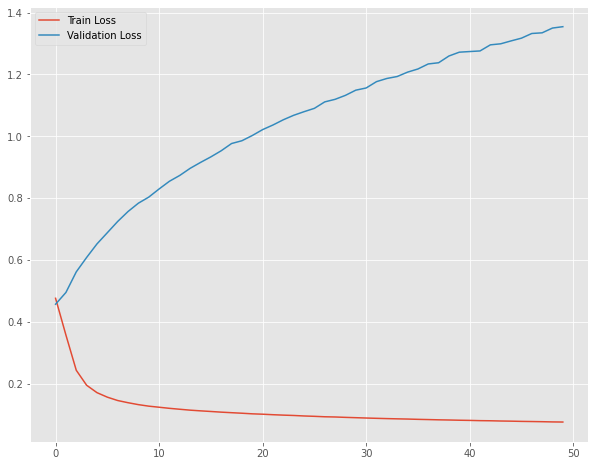

In [15]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())
plt.figure(figsize=(10,8))
plt.plot(loss.binary_crossentropy,label='Train Loss')
plt.plot(loss.val_binary_crossentropy,label='Validation Loss')
plt.legend()
plt.show()

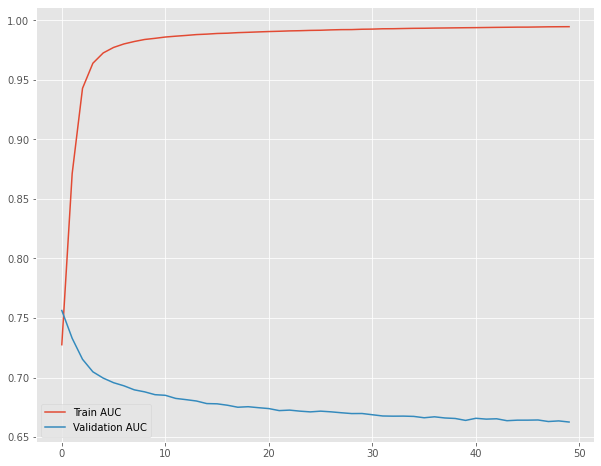

In [16]:
plt.figure(figsize=(10,8))
plt.plot(loss.auc,label='Train AUC')
plt.plot(loss.val_auc,label='Validation AUC')
plt.legend()
plt.show()

### Why this dataset happened overfitting?
### But in movie len dataset this DeepFM good performance
### Movie Len : https://www.kaggle.com/code/leejunseok97/deepfm-movie-len-pytorch

In [9]:
# class FM(nn.Module):
#     def __init__(self):
#         super().__init__()
    
#     def forward(self,x):
#         ix = (torch.sum(x,dim=1) ** 2) - (torch.sum(x ** 2,dim=1))
#         ix = torch.sum(ix,dim=1,keepdim=True)
#         return 0.5 *  ix

In [10]:
# class feat_linear(nn.Module):
#     def __init__(self,field_dim_list):
#         super().__init__()
#         self.fc = nn.Embedding(sum(field_dim_list),1)
#         self.bias = nn.Parameter(torch.zeros((1,)))
#         self.offsets = np.array((0, *np.cumsum(field_dim_list)[:-1]),dtype=np.long)
#     def forward(self,x):
#         x += x.new_tensor(self.offsets).unsqueeze(0)
#         return torch.sum(self.fc(x),dim=1) + self.bias

In [11]:
# class feat_embedding(nn.Module):
#     def __init__(self,field_dim_list,emb_dim):
#         super().__init__()
#         self.embedding = nn.Embedding(sum(field_dim_list),emb_dim)
#         self.offsets = np.array((0, *np.cumsum(field_dim_list)[:-1]),dtype=np.long)
#         nn.init.xavier_uniform_(self.embedding.weight.data)
#     def forward(self,x):
#         x += x.new_tensor(self.offsets).unsqueeze(0)
#         return self.embedding(x)

In [12]:
# class MLP(nn.Module):
#     def __init__(self,input_dim,embed_dim):
#         super().__init__()
#         self.seq = nn.Sequential(
#             nn.Linear(input_dim,embed_dim),
#             nn.BatchNorm1d(embed_dim),
#             nn.Hardswish(),
#             nn.Dropout(0.5),
#             nn.Linear(embed_dim,1)
#         )
#     def forward(self,x):
#         return self.seq(x)

In [13]:
# class DeepFM(nn.Module):
#     def __init__(self,field_dim_list,embed_dim,mlp_dims):
#         super().__init__()
#         self.linear = feat_linear(field_dim_list)
#         self.fm = FM()
#         self.embedding = feat_embedding(field_dim_list,emb_dim=embed_dim)
#         self.embed_output_dim = len(field_dim_list) * embed_dim
#         self.mlp = MLP(self.embed_output_dim , mlp_dims)
#     def forward(self,x):
#         embed_x = self.embedding(x)
#         output = self.linear(x) + self.fm(embed_x) + self.mlp(embed_x.view(-1,self.embed_output_dim))
#         return torch.sigmoid(output.squeeze(1))